# Fully Convolutional Interior/Edge Segmentation for 2D Data

---

Classifies each pixel as either Cell Edge, Cell Interior, or Background.

There are 2 different Cell Edge classes (Cell-Cell Boundary and Cell-Background Boundary)

In [1]:
import os
import errno

import numpy as np

import deepcell

Using TensorFlow backend.


### Load the training data

In [2]:
# Download the data (saves to ~/.keras/datasets)
filename = 'HeLa_S3.npz'
(X_train, y_train), (X_test, y_test) = deepcell.datasets.hela_s3.load_data(filename)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

3432783872/3432776206 [==============================] - 117s 0us/step
X.shape: (6208, 216, 256, 1)
y.shape: (6208, 216, 256, 1)


### Set up filepath constants

In [3]:
# the path to the data file is currently required for `train_model_()` functions

# NOTE: Change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

DATA_FILE = os.path.join(DATA_DIR, filename)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [4]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

### Set up training parameters

In [5]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

n_epoch = 3  # Number of training epochs
test_size = .10  # % of data saved as test
norm_method = 'std'  # data normalization
receptive_field = 61  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 3  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

# Transformation settings
transform = 'deepcell'
dilation_radius = 1  # change dilation radius for edge dilation
n_features = 4  # (cell-background edge, cell-cell edge, cell interior, background)

### First, create a foreground/background separation model

#### Instantiate the fgbg model

In [6]:
from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_skip_2D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=tuple(X_train.shape[1:]),
    last_only=False)

#### Train the model fgbg model

In [7]:
from deepcell.training import train_model_conv

fgbg_model = train_model_conv(
    model=fgbg_model,
    dataset=DATA_FILE,  # full path to npz file
    expt='conv_fgbg',
    test_size=test_size,
    optimizer=optimizer,
    n_epoch=n_epoch,
    batch_size=batch_size,
    transform='fgbg',
    model_dir=MODEL_DIR,
    log_dir=LOG_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2))

X_train shape: (6984, 216, 256, 1)
y_train shape: (6984, 216, 256, 1)
X_test shape: (776, 216, 256, 1)
y_test shape: (776, 216, 256, 1)
Output Shape: (None, 216, 256, 2)
Number of Classes: 2
Training on 1 GPUs
Epoch 1/3
6983/6984 [============================>.] - ETA: 0s - loss: 0.1966 - model_loss: 0.0454 - model_1_loss: 0.0420 - model_2_loss: 0.0412 - model_3_loss: 0.0396 - model_acc: 0.9476 - model_1_acc: 0.9492 - model_2_acc: 0.9487 - model_3_acc: 0.9499
Epoch 00001: val_loss improved from inf to 0.27086, saving model to /data/models/2018-12-13_HeLa_S3_conv_fgbg.h5
6984/6984 [==============================] - 983s 141ms/step - loss: 0.1966 - model_loss: 0.0454 - model_1_loss: 0.0420 - model_2_loss: 0.0412 - model_3_loss: 0.0396 - model_acc: 0.9476 - model_1_acc: 0.9492 - model_2_acc: 0.9487 - model_3_acc: 0.9499 - val_loss: 0.2709 - val_model_loss: 0.0653 - val_model_1_loss: 0.0576 - val_model_2_loss: 0.0603 - val_model_3_loss: 0.0591 - val_model_acc: 0.9821 - val_model_1_acc: 0.9

### Next, Create a model for the watershed energy transform

#### Instantiate the deepcell transform model

In [8]:
from deepcell import model_zoo

conv_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=fgbg_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=n_features,
    norm_method=norm_method,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=tuple(X_train.shape[1:]))

#### Train the deepcell transform model

In [9]:
from deepcell.training import train_model_conv

conv_model = train_model_conv(
    model=conv_model,
    dataset=DATA_FILE,  # full path to npz file
    expt='conv',
    test_size=test_size,
    transform=transform,
    dilation_radius=dilation_radius,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    log_dir=LOG_DIR,
    model_dir=MODEL_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2))

X_train shape: (6984, 216, 256, 1)
y_train shape: (6984, 216, 256, 1)
X_test shape: (776, 216, 256, 1)
y_test shape: (776, 216, 256, 1)
Output Shape: (None, 216, 256, 4)
Number of Classes: 4
Training on 1 GPUs
Epoch 1/3
6983/6984 [============================>.] - ETA: 0s - loss: 0.3080 - acc: 0.7982
Epoch 00001: val_loss improved from inf to 0.35446, saving model to /data/models/2018-12-13_HeLa_S3_conv.h5
6984/6984 [==============================] - 1382s 198ms/step - loss: 0.3080 - acc: 0.7982 - val_loss: 0.3545 - val_acc: 0.9407
Epoch 2/3
6983/6984 [============================>.] - ETA: 0s - loss: 0.2775 - acc: 0.8050
Epoch 00002: val_loss improved from 0.35446 to 0.34602, saving model to /data/models/2018-12-13_HeLa_S3_conv.h5
6984/6984 [==============================] - 1367s 196ms/step - loss: 0.2775 - acc: 0.8050 - val_loss: 0.3460 - val_acc: 0.9443
Epoch 3/3
6983/6984 [============================>.] - ETA: 0s - loss: 0.2706 - acc: 0.8059
Epoch 00003: val_loss improved from 0.

### Run the model

In [10]:
# With the trained model, make predictions on testing data
test_images = conv_model.predict(X_test)

print('model output shape:', test_images.shape)

model output shape: (1552, 216, 256, 4)


Image number: 1198


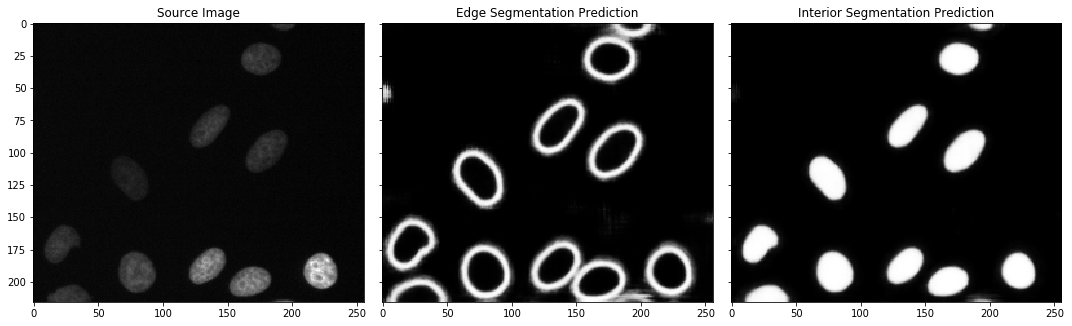

In [11]:
# Plot the results
import matplotlib.pyplot as plt

index = np.random.randint(low=0, high=X_test.shape[0])
print('Image number:', index)

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, ..., 0], cmap='gray')
ax[0].set_title('Source Image')

ax[1].imshow(test_images[index, ..., 0] + test_images[index, ..., 1], cmap='gray')
ax[1].set_title('Edge Segmentation Prediction')

ax[2].imshow(test_images[index, ..., 2], cmap='gray')
ax[2].set_title('Interior Segmentation Prediction')

fig.tight_layout()
plt.show()